In [1]:
import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src import IntervalEstimator, get_feed_id

sns.set_style("darkgrid")
sns.set_context("notebook")

In the general caching intervals are a Poisson point process. Therefore, the pdf of time between events is an exponential distribution, with a rate parameter $\lambda$ (the caching interval),

$pdf = \lambda e^{{-\lambda x}}$

Feeds with normal publish times have the ground truth values for timestamps of events. We can calculate the intervals betweeen each event (after sorting then by time) then view the histogram and fit a exponential distribution to compute $\lambda$. 

For example, visualising the this for first example (using the time_published)

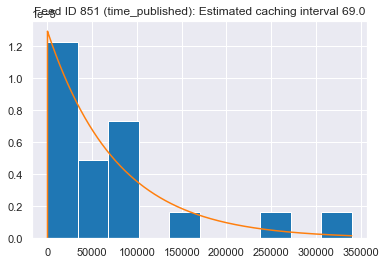

69.0

In [2]:
normal_publish_times_list = glob.glob(None)

interval_estimator = IntervalEstimator()

filename = normal_publish_times_list[0]
feed_id = get_feed_id(filename)
df = pd.read_csv(filename)
interval_estimator.predict_one_feed(df, key_to_use='time_published', feed_id=feed_id)

Then do the same thing, only using time_created...

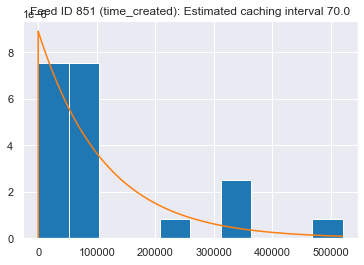

70.0

In [3]:
interval_estimator.predict_one_feed(df, key_to_use='time_created', feed_id=feed_id)

Do the same process to get the groundtruth intervals from time_published, and estimated intervals from time_created

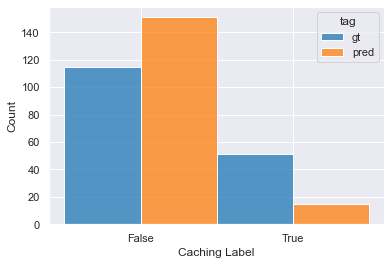

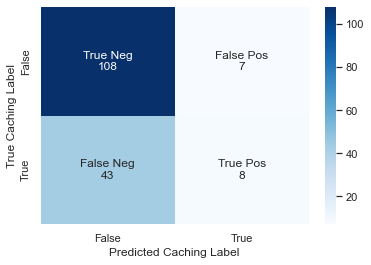

In [4]:
from src import make_plots

gt = {'feed_id': [],
      'y_true': [],
      'y_pred': []}

for idx, filename in enumerate(normal_publish_times_list):
    df = pd.read_csv(filename)
    gt['y_true'].append(interval_estimator.predict_one_feed(df, key_to_use='time_published', feed_id=None))
    gt['y_pred'].append(interval_estimator.predict_one_feed(df, key_to_use='time_created', feed_id=None))
    gt['feed_id'].append(filename)

gt = pd.DataFrame(gt)

gt['labels'] =  gt['y_true'] >= 600
gt['label_preds'] = gt['y_pred'] >= 600


make_plots(gt)

From the above plots, there looks to be some high frequency (low time interval) noise in the time_created values (due to some latency in the poll process I supppose). This causes bad predictions of caching interval, and therefore misclassification as "not considered as cached".

To remove this high frequency noise, I implemented a threshold based clustering algorithm to cluster time stamps in time_created to combine article creations within the given theshold window into a single time stamp (i.e. assume they were updated at the same time).

The threshold based clustering algorithm is:
1. Sort values in feed by time stamp
1. Initialise the first cluster C_0 to start at the first article time stamp.
1. for each article in feed, with time created t_i:
    1. Compute dt between creation times t_i and t_(i-1)
    1. If dt <= threshold, is it assigned to current cluster C_k and updated cluster centre (mean of cluster time stamps)
    1. If dt > threshold, a new cluster C_(k+1) is initialised at t_i
1. Fit exponential distibution to pdf of sequential inter-cluster intervals to estimate cache interval, $\lambda$.

As a classification task, I then optimise the cluster threshold with normal published times feed:
1. groundtruth labels is that extract using the time published, as mentioned at the start
1. for threshold in range(something sensible)
    1. Predict cache intervals for feed, with cluster_threshold=threshold
    1. Assign predicted labels as cache intervals >= 600
    1. Compute performance metrics vs groundtruth labels
1. Select threshold that maximised the chosen classification metric (e.g. precision, recall, f1_score)

Using F1_score, recall and precision as optimisation metrics find values of 25, 25 and ~300 seconds respectively. This seems sensible as it is stated polls are approx. every 60 seconds so any latency/noise from polling and creation should probbaly be resolved in <60s. I only optimised the threshold in the interval [0, 60].


In [5]:
from sklearn.metrics import precision_recall_fscore_support

def optimise_over_threshold_range(perf, min_t, max_t, step_size):
    for threshold in range(min_t, max_t, step_size):
        interval_estimator.threshold = threshold
        preds = []
        for filename in gt['feed_id']:
            df = pd.read_csv(filename)
            cache_int = interval_estimator.predict_one_feed(df, key_to_use='time_created', feed_id=None)
            preds.append(cache_int)

        label_preds = [1 if i >= 600 else 0 for i in preds]
        cls_perf = precision_recall_fscore_support(gt['labels'], label_preds, average='weighted')
        prec, rec, f1_score, support = cls_perf
        perf['precision'].append(prec)
        perf['recall'].append(rec)
        perf['f1 score'].append(f1_score)
        perf['t'].append(threshold)
    return perf

perf = {
    'precision': [],
    'recall': [],
    'f1 score': [],
    't': []
}
# optimise small scale
print('Optimise in the interval [0, 60].')
perf = optimise_over_threshold_range(perf, 0, 60, 1)

# optimise over larger scale
print('Optimise in the interval [60, 600].')
perf = optimise_over_threshold_range(perf, 60, 600, 30)

perf = pd.DataFrame(perf)
interval_estimator.threshold = perf['t'][perf['f1 score'].argmax()]

Optimise in the interval [0, 60].
Optimise in the interval [60, 600].


Best PRECISION model has t=300


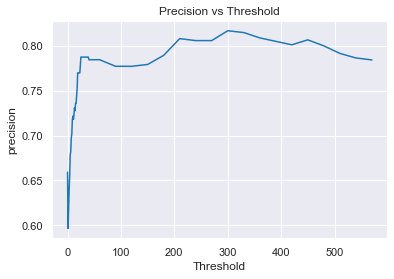

Best RECALL model has t=25


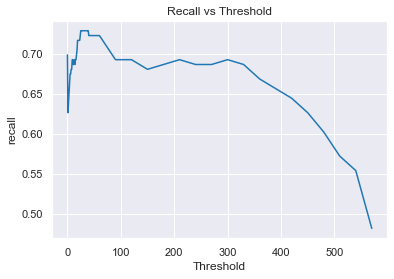

Best F1 SCORE model has t=25


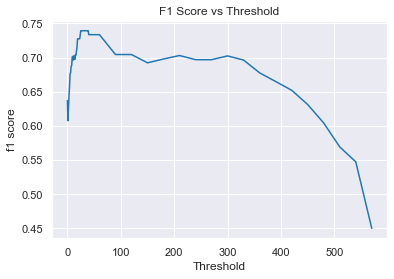

In [7]:
for key in perf.columns:
    if key != 't':
        print('Best {} model has t={}'.format(key.upper(), perf['t'][perf[key].argmax()]))

        sns.lineplot(data=perf, x='t', y=key)
        plt.title('{} vs Threshold'.format(key.title()))
        plt.xlabel('Threshold')
        plt.show()

        label_preds = []

        interval_estimator.threshold = perf['t'][perf[key].argmax()]
        for idx, filename in enumerate(normal_publish_times_list):
            df = pd.read_csv(filename)
            label_preds.append(interval_estimator.predict_one_feed(df, key_to_use='time_created', feed_id=None))

        label_preds = [True if i >= 600 else False for i in label_preds]
        gt['label_preds'] = label_preds

Run the classifier on the time_created values to see predictions now match up.

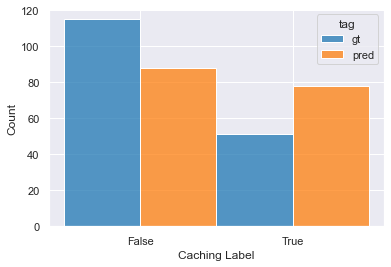

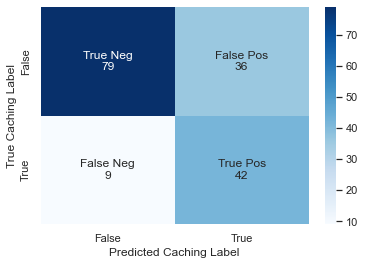

In [8]:
y_preds = []
for idx, filename in enumerate(normal_publish_times_list):
    df = pd.read_csv(filename)
    y_preds.append(interval_estimator.predict_one_feed(df, key_to_use='time_created', feed_id=None))

gt['y_pred'] = y_preds

gt['label_preds'] = gt['y_pred'] >= 600


make_plots(gt)

Far more true positives are detected and far fewer false negatives, but True negatives have decreased a little and false positives have increased.

There care alternative methods.
1. Generally use the same process, but instead optimise the regression of cache interval rather than classification of whether the feed is considered cached.
1. Modelling the noise/latency in the time_created specifically, given that then exponential distribution of each feed is known from time_published.